In [1]:
import os
os.chdir("/Users/gregou/electron_defect_interaction")

import numpy as np
import matplotlib.pyplot as plt

from electron_defect_interaction.analysis.defect_me.defect_me import *
from electron_defect_interaction.utils.get_utils import *
from electron_defect_interaction.utils.lattice_utils import red_to_cart
from electron_defect_interaction.utils.fft_utils import *
from electron_defect_interaction.utils.pw_utils import *
from electron_defect_interaction.analysis.wfk.wfk import compute_psi_nk

In [2]:
uc_wfk_path="data/graphene/unit_cell/5x5x1/abinit/graphene_w90_5x5x1o_DS2_WFK.nc"
sc_p_wfk_path="data/graphene/supercell/pristine/gamma/graphene_pristine_sc_5x5_go_WFK.nc"
sc_d_wfk_path="data/graphene/supercell/defective/vac1a1/gamma/graphene_vac1_a1o_WFK.nc"
sc_p_pot_path="data/graphene/supercell/pristine/gamma/graphene_pristine_sc_5x5_go_POT.nc"
sc_d_pot_path ="data/graphene/supercell/defective/vac1a1/gamma/graphene_vac1_a1o_POT.nc"
psp8_path = "data/graphene/C.psp8"

M_NL_p = compute_M_NL(uc_wfk_path, sc_p_wfk_path, psp8_path)
M_L = compute_M_L_r(uc_wfk_path, sc_p_wfk_path, sc_p_pot_path, sc_d_pot_path, bands=[3,4], subtract_mean=False)

.psp8 file:  C     ONCVPSP-3.2.3.1  r_core=   1.20440   1.26326
Computing wavefunctions
Computed 25% of wavefunctions, (7/25) kpoints
Computed 50% of wavefunctions, (13/25) kpoints
Computed 75% of wavefunctions, (19/25) kpoints
Computed 100% of wavefunctions, (25/25) kpoints
Done! Wavefunctions are normalized.
Computing local matrix elements
Computed 25% of matrix elements (625/2500)
Computed 50% of matrix elements (1250/2500)
Computed 75% of matrix elements (1875/2500)
Computed 100% of matrix elements (2500/2500)


In [3]:
M_NL_d = compute_M_NL(uc_wfk_path, sc_d_wfk_path, psp8_path)

.psp8 file:  C     ONCVPSP-3.2.3.1  r_core=   1.20440   1.26326


In [4]:
M_NL = M_NL_d - M_NL_p

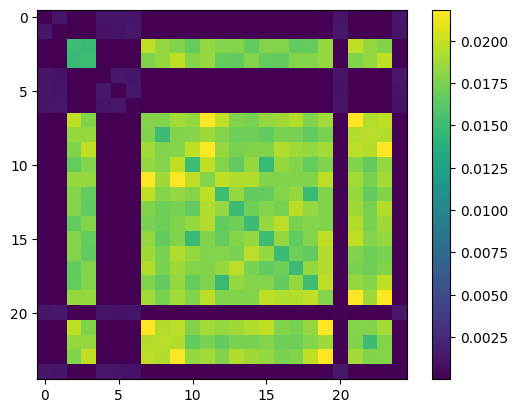

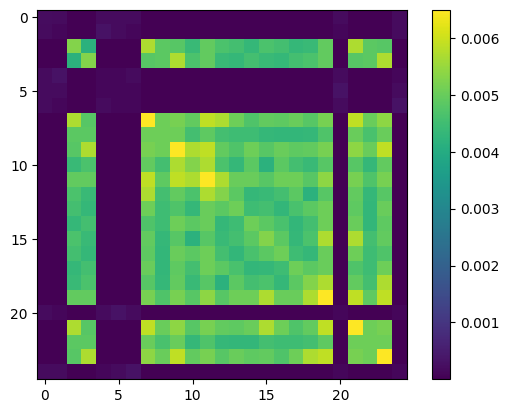

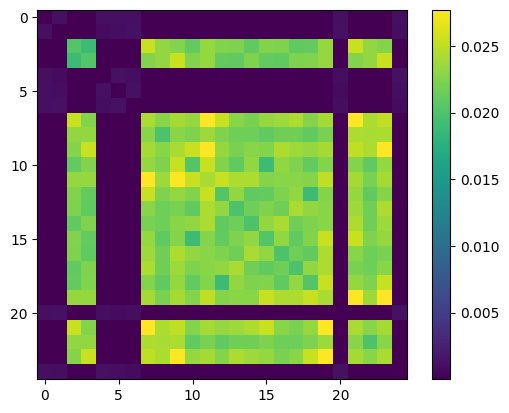

In [15]:
Mnl = M_NL[4,:,4,:]
Ml = M_L[1,:,1,:]

plt.imshow(np.abs(Ml))
plt.colorbar()
plt.show()

plt.imshow(np.abs(Mnl))
plt.colorbar()
plt.show()

plt.imshow(np.abs(Ml+Mnl))
plt.colorbar()
plt.show()

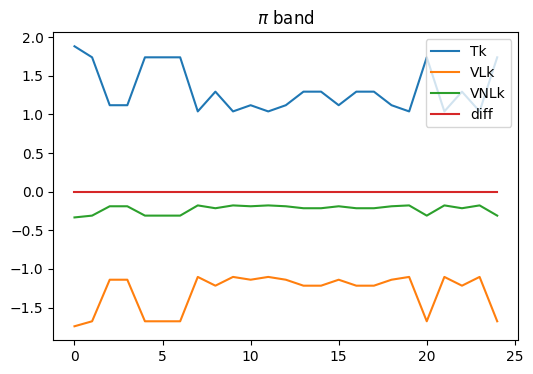

Max difference: 1.192184211573632e-08


In [10]:
VNLk = np.diag(M_NL[3,:,3,:].real)
VLk = np.diag(M_L[0,:,0,:].real)

C_nkg, nG = get_C_nk(uc_wfk_path)
G_red = get_G_red(uc_wfk_path)
k_red = get_kpt_red(uc_wfk_path)
B_uc, _ = get_B_volume(uc_wfk_path)

eig = get_eigenvalues(uc_wfk_path)
eig_k = eig[3, :]

nband, nkpt, nG_max = C_nkg.shape

K_red = k_red[:, np.newaxis, :] + G_red

K = red_to_cart(K_red, B_uc)
# Compute kinetic energy of band pi
Tk = np.zeros(nkpt)
for ik in range(nkpt):
    Kg = K[ik, :nG[ik], :]
    K2 = np.einsum('gi,gi->g', Kg, Kg)
    w = np.abs(C_nkg[3,ik, :nG[ik]])**2
    Tk[ik] = 0.5 * np.dot(w, K2) 

dff = Tk+VLk+VNLk - eig_k

fig, ax = plt.subplots(figsize=(6,4), dpi=100)
ax.plot(Tk, label='Tk')
ax.plot(VLk, label='VLk')
ax.plot(VNLk, label='VNLk')
# plt.plot(eig_k, label='Ek')
ax.plot(dff, label='diff')
ax.set_title('$\\pi$ band')
ax.legend()
plt.show()
print('Max difference:', np.max(dff - np.mean(dff)))